In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
#final date
end_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
end_date

('2017-08-23')

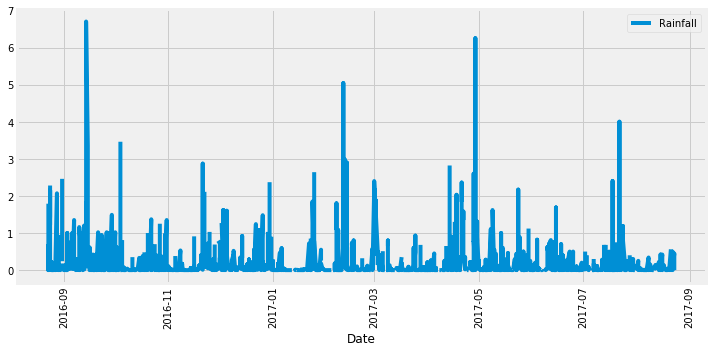

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
end_date = dt.date(2017, 8, 23)

# Calculate the date 1 year ago from the last data point in the database
start_date = end_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_scores = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= start_date).\
    order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_scores, columns=["date", "percipitation"])
prcp_df["date"] = pd.to_datetime(prcp_df["date"])
prcp_df = prcp_df.set_index("date")

# Sort the dataframe by date
prcp_df = prcp_df.sort_values(by="date")

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,5))
plt.plot(prcp_df, label='Rainfall')
plt.xlabel("Date")
plt.xticks(rotation='90')
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [23]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,percipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [24]:
# Design a query to show how many stations are available in this dataset?
sel = [func.count(func.distinct(Station.station)).label("count_stations")]
all_stations = session.query(*sel).all()
print(all_stations[0].count_stations)

9


In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station,  
      func.count(Measurement.station)]
active_station = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

for station in active_station:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
busiest_station_id = active_station[0].station

sel = [Measurement.station,\
      func.min(Measurement.tobs),\
      func.max(Measurement.tobs),\
      func.avg(Measurement.tobs)
      ]
busiest_station = session.query(*sel).\
    filter(Measurement.station == busiest_station_id).\
    group_by(Measurement.station).all()
    
print(busiest_station)

[('USC00519281', 54.0, 85.0, 71.66378066378067)]


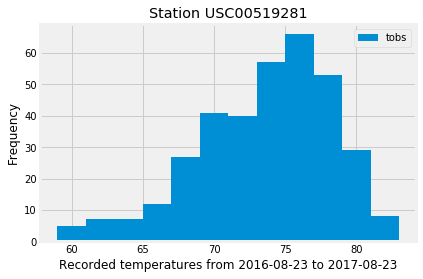

In [29]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps = session.query(Measurement.tobs).\
    filter(Measurement.station == busiest_station_id,
    Measurement.date >= start_date.strftime("%Y-%m-%d")).all()

df_temp = pd.DataFrame(temps)
df_temp.plot.hist(bins=12)
plt.xlabel('Recorded temperatures from ' + str(start_date) + " to " + str(end_date))
plt.ylabel('Frequency')
plt.title('Station ' + busiest_station_id)
plt.grid(True)
plt.show()